## 전체 흐름 요약 (참고)
1. 연도 **EDA**
2. rating **EDA**  
---
3. Item based CF 구조 **코드**(rating 기반 dot production)
4. rating 편향 **코드**
5. 유사도 행렬 가중치 **코드**
6. 연도 **코드**  
---
7. 각 모델 성능 평가 비교

# 전처리된 데이터 불러오기
csv 불러온 후 id 데이터 str 형변환

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

movies_df = pd.read_csv("data/movies_refined.csv")
ratings_df = pd.read_csv("data/ratings_refined.csv")
movies_df['movie_id'] = movies_df['movie_id'].astype(str)
ratings_df['user_id'] = ratings_df['user_id'].astype(str)
ratings_df['movie_id'] = ratings_df['movie_id'].astype(str)

# 연도 EDA
“year_gap의 분포는 0–10 구간에 대부분의 데이터가 집중되어 있고,  
20년 이후에는 급격히 희소해지는 long-tailed 형태를 보였다.  
또한 rating vs gap 패턴을 Lowess curve, equal-range binning, smoothing curve로 분석한 결과,  
9~14년 구간이 가장 낮은 평점을 기록하고,  
그 이후 구간에서 평점 상승이 가장 뚜렷했다.
Quantile bins(6 bins) 구간으로 나누었을 때 가장 변화가 뚜렷하다고 판단

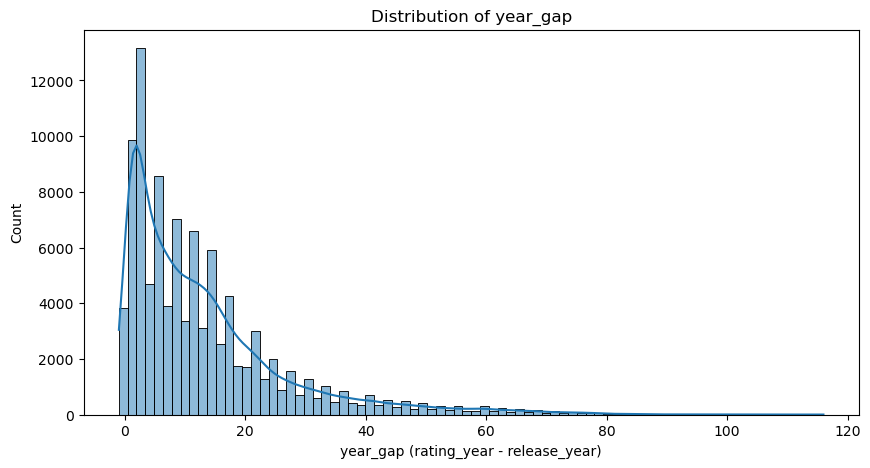

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.merge(ratings_df, movies_df, on='movie_id', how='left')
df['release_year'] = df['title'].str.extract(r'\((\d{4})\)').astype(float)
df['rating_year'] = pd.to_datetime(df['timestamp'], unit='s').dt.year
df['year_gap'] = df['rating_year'] - df['release_year']

plt.figure(figsize=(10,5))
sns.histplot(df['year_gap'], bins=80, kde=True)
plt.title("Distribution of year_gap")
plt.xlabel("year_gap (rating_year - release_year)")
plt.ylabel("Count")
plt.show()


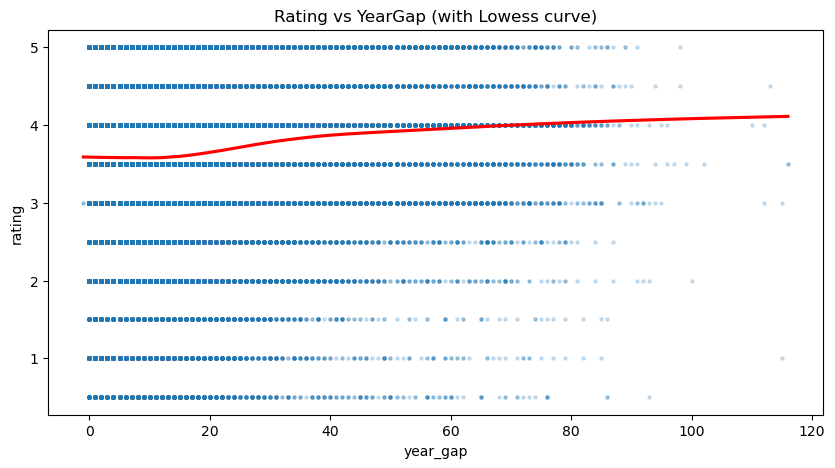

In [3]:
plt.figure(figsize=(10,5))
sns.regplot(
    data=df,
    x='year_gap', y='rating',
    scatter_kws={'s':5, 'alpha':0.2},
    lowess=True,
    line_kws={'color':'red'}
)
plt.title("Rating vs YearGap (with Lowess curve)")
plt.xlabel("year_gap")
plt.ylabel("rating")
plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_34480\272473281.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby('bin')['rating'].mean()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_34480\272473281.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df.groupby('bin')['rating'].mean()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_34480\272473281.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silen

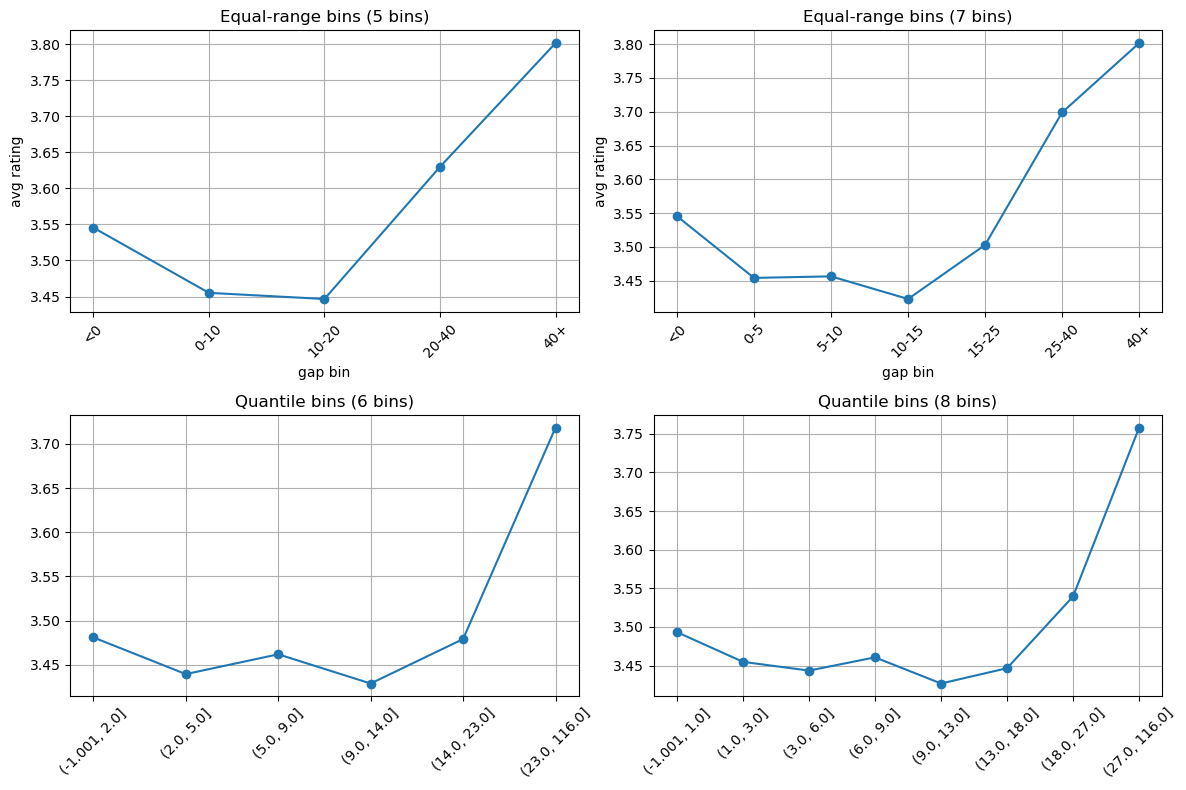

In [4]:
def plot_bin_strategy(df, bins, labels=None, title=""):
    df = df.copy()
    df['bin'] = pd.cut(df['year_gap'], bins=bins, labels=labels, include_lowest=True)
    tmp = df.groupby('bin')['rating'].mean()

    plt.plot(tmp.index.astype(str), tmp.values, marker='o')
    plt.title(title)
    plt.xlabel("gap bin")
    plt.ylabel("avg rating")
    plt.xticks(rotation=45)
    plt.grid(True)

plt.figure(figsize=(12,8))

# 1. 등간격 5개 bin
plt.subplot(2,2,1)
bins1 = [-50, 0, 10, 20, 40, 100]
labels1 = ['<0','0-10','10-20','20-40','40+']
plot_bin_strategy(df, bins1, labels1, "Equal-range bins (5 bins)")

# 2. 등간격 7개 bin
plt.subplot(2,2,2)
bins2 = [-50, 0, 5, 10, 15, 25, 40, 100]
labels2 = ['<0','0-5','5-10','10-15','15-25','25-40','40+']
plot_bin_strategy(df, bins2, labels2, "Equal-range bins (7 bins)")

# 3. quantile 6개 bin
plt.subplot(2,2,3)
df['qbin6'] = pd.qcut(df['year_gap'], q=6)
tmp = df.groupby('qbin6')['rating'].mean()
plt.plot(tmp.index.astype(str), tmp.values, marker='o')
plt.title("Quantile bins (6 bins)")
plt.xticks(rotation=45)
plt.grid(True)

# 4. quantile 8개 bin
plt.subplot(2,2,4)
df['qbin8'] = pd.qcut(df['year_gap'], q=8)
tmp = df.groupby('qbin8')['rating'].mean()
plt.plot(tmp.index.astype(str), tmp.values, marker='o')
plt.title("Quantile bins (8 bins)")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()


# rating EDA
1~2명이 한 영화에 대해 평가한 경우가 가장 많았음.  
해당 데이터로 유사도 행렬을 만들면 노이즈가 낀 행렬로 성능이 불안정할 것으로 예상.  
유사도 행렬에 각 영화를 시청한 유저 수 기반 가중치를 부여하기로 결정.

In [5]:
# 영화별 rating 개수
movie_counts = ratings_df.groupby("movie_id")["rating"].count().reset_index()
movie_counts.columns = ["movie_id", "rating_count"]

movie_counts.head()

,movie_id,rating_count
0,1,215
1,10,132
2,100,14
3,100044,1
4,100068,1


In [6]:
movie_counts["rating_count"].describe()

count    9685.000000
mean       10.406298
std        22.438590
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating_count, dtype: float64

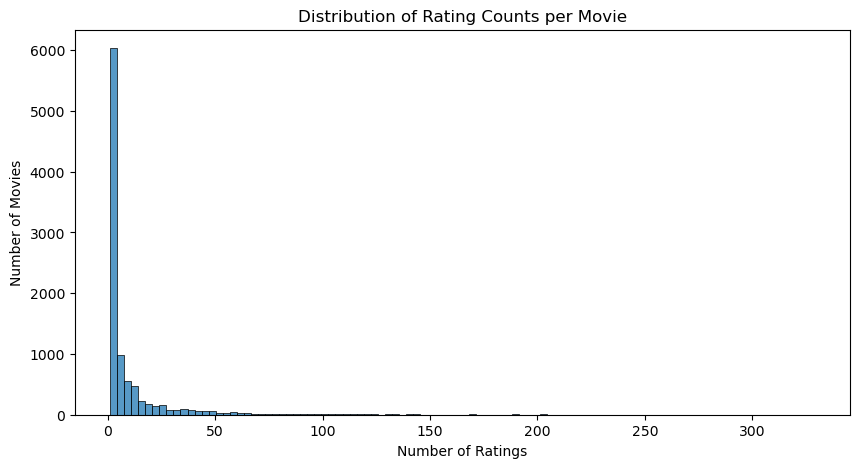

In [7]:
plt.figure(figsize=(10,5))
sns.histplot(movie_counts["rating_count"], bins=100, kde=False)
plt.title("Distribution of Rating Counts per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.show()


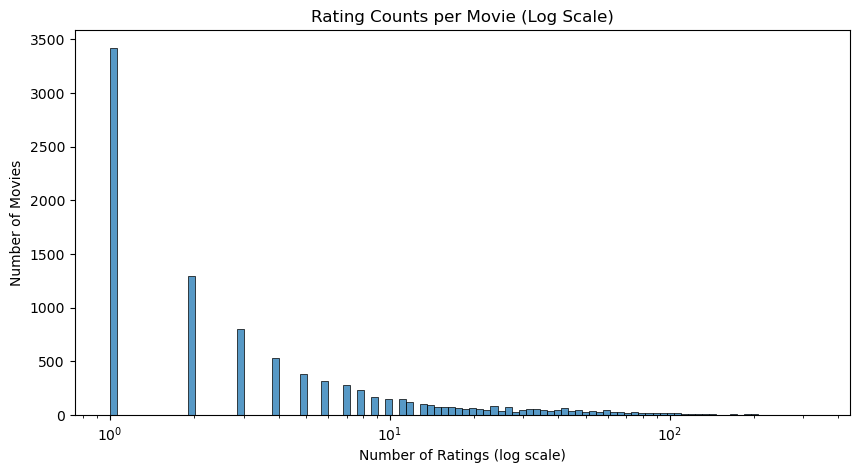

In [8]:
plt.figure(figsize=(10,5))
sns.histplot(movie_counts["rating_count"], bins=100, log_scale=True)
plt.title("Rating Counts per Movie (Log Scale)")
plt.xlabel("Number of Ratings (log scale)")
plt.ylabel("Number of Movies")
plt.show()

In [9]:
movie_counts.sort_values(by="rating_count", ascending=False).head(10)


,movie_id,rating_count
4331,356,329
3865,318,317
3602,296,307
6784,593,279
2948,2571,278
3013,260,251
5622,480,238
397,110,237
6744,589,224
6104,527,220


In [10]:
movie_counts.sort_values(by="rating_count").head(10)


,movie_id,rating_count
717,119964,1
9669,99574,1
9671,99636,1
9672,99638,1
9673,99721,1
3879,31909,1
9675,99750,1
3880,3192,1
6942,6086,1
9659,99122,1


# Item-based CF 메인 구조
   - R_train: user x item 평점 행렬
   - S: item x item 유사도(cosine, 내부적으로 dot product)
   - R_hat_cf: Item-based 예측

* 유사도 행렬 만들 때 float64 -> float32로 변경. 메모리/시간 절약  (default: float64)  
float32는 소수점 약 7자리  
float64는 소수점 약 15자리  
추천시스템에서는 순위 변화에 기여할 수 없다고 판단  
[float32] 유사도 계산 시간: 0.2531 초  
[float64] 유사도 계산 시간: 0.3716 초  


   ★ 약 **32% 빠르게 유사도 계산**이 가능

In [11]:
movie_ratings_df = pd.merge(ratings_df, movies_df, on='movie_id', how='left')
movie_ratings_df.head()

,user_id,movie_id,rating,timestamp,title,year,genres
0,429,421,4.0,828124615,Black Beauty (1994),1994,Adventure Children Drama
1,429,420,2.0,828124615,Beverly Hills Cop III (1994),1994,Action Comedy Crime Thriller
2,429,434,4.0,828124615,Cliffhanger (1993),1993,Action Adventure Thriller
3,429,432,3.0,828124615,City Slickers II: The Legend of Curly's Gold (...,1994,Adventure Comedy Western
4,429,22,4.0,828124615,Copycat (1995),1995,Crime Drama Horror Mystery Thriller


### Rating 편향 보정

In [12]:
# === 평점 편향 보정: 유저별 평균 기준 중심화 rating_centered 생성 ===

# 유저별 평균 평점
user_mean = (
    movie_ratings_df
    .groupby("user_id")["rating"]
    .mean()
    .rename("user_mean_rating")
)

# ratings_df에 유저 평균 붙이기
movie_ratings_df = movie_ratings_df.merge(user_mean, on="user_id", how="left")

# ★ 평균에서 얼마나 벗어났는지 나타내는 중심화 평점
movie_ratings_df["rating_centered"] = movie_ratings_df["rating"] - movie_ratings_df["user_mean_rating"]

movie_ratings_df[["user_id", "movie_id", "rating", "user_mean_rating", "rating_centered"]].head()

,user_id,movie_id,rating,user_mean_rating,rating_centered
0,429,421,4.0,3.982759,0.017241
1,429,420,2.0,3.982759,-1.982759
2,429,434,4.0,3.982759,0.017241
3,429,432,3.0,3.982759,-0.982759
4,429,22,4.0,3.982759,0.017241


In [13]:
# ★ user_id × movie_id 행렬 (values = rating_centered)
R_centered = movie_ratings_df.pivot_table(
    values="rating_centered",
    index="user_id",
    columns="movie_id",
    fill_value=0.0,  # 안 본 영화는 0
).astype(np.float32)


print("user_item_matrix shape:", R_centered.shape) #(user, n_items) rating 편향 값

# cosine_similarity
S_centered = cosine_similarity(R_centered.T)  # (n_items x n_items) 유사도 행렬
np.fill_diagonal(S_centered, 0.0) # 자기 자신과의 유사도는 0


print("item_sim_matrix shape:", S_centered.shape)

user_item_matrix shape: (610, 9685)
item_sim_matrix shape: (9685, 9685)


## 기본 baseline 유사도 행렬 item_similiarity_df

In [14]:
# user x item 행렬
R_df = (movie_ratings_df.pivot_table(
    index='user_id',
    columns='movie_id',
    values='rating',
    fill_value=0.0
    )
    .sort_index(axis=0)
    .sort_index(axis=1)
    .astype(np.float32)
)

print("R shape:", R_df.shape)
R_df.head()

R shape: (610, 9685)


movie_id,1,10,100,100044,100068,100083,100106,100159,100163,100194,...,99750,99764,998,99813,99846,99853,999,99910,99917,99992
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# item 벡터 = 각 영화의 유저별 평점 벡터
item_vectors = R_df.T.values   # (n_items x n_users)

# item-item 유사도 (cosine)
S = cosine_similarity(item_vectors)  # (n_items x n_items)
np.fill_diagonal(S, 0.0) # 자기 자신과의 유사도는 0

print(S.dtype)
print("유사도 행렬 S shape:", S.shape)
print(S.shape)

float32
유사도 행렬 S shape: (9685, 9685)
(9685, 9685)


## 평가 유저 수에 따른 유사도 행렬 가중치

1. 공통 유저 수 행렬 co_count 계산
2. Weight 계산


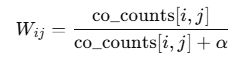


S_W = S * W

S[i,j]에 곱해지는 W[i,j]는 “i 영화도 보고 j 영화도 본 유저 수” 기반 신뢰도 가중치 

공동 시청 인원이 많을수록 S[i,j]가 보존되고, 적을수록 S[i,j]를 약하게 변환

In [16]:
import scipy.sparse as sp
def apply_weight_similarity(S):
    # B = (item_vectors > 0)
    B = (item_vectors > 0).astype(np.uint16)

    # ★ scipy CSR sparse matrix는 0이 있는 영역을 스킵하면서 연산, 속도 향상
    B_sparse = sp.csr_matrix(B)   # (n_items x n_users)

    # 공통 유저 수 계산
    co_counts = (B_sparse @ B_sparse.T).toarray()
    co_counts_float = co_counts.astype(np.float32)

    alpha = 20  # 하이퍼파라미터 (5,10,15,20,25 테스트 하였을 때, 20이 성능이 제일 좋았음)
    # ★ (n_items x n_items)
    W = co_counts_float / (co_counts_float + alpha)   

    S_W = S * W          # element-wise 곱
    np.fill_diagonal(S_W, 0.0)
    return S_W

## dot production 기반 평점 예측 모델
input:
1. S : (n_items × n_items) 유사도 행렬
2. R_df : (user × n_items rating)
3. use_centering : rating 편향 유사도 사용 여부

output:
1. 예측 별점 df

In [17]:
def modeling(S, R_df, movie_ratings_df, use_centering=False):

    # -----------------------------------------------------
    # 0. NumPy 배열로 변환 및 기본 정보
    # -----------------------------------------------------
    R = R_df.values.astype(np.float32)     # (n_users × n_items)
    S = S.astype(np.float32)                     # (n_items × n_items)
    absS = np.abs(S)

    itemIds = R_df.columns.tolist()        # movie_id 리스트
    userIds = R_df.index.tolist()

    # -----------------------------------------------------
    # 1. 전체 유저 × 전체 아이템 dot product 예측
    # -----------------------------------------------------

    numerator = S @ R.T                          # ★ (n_items × n_users) 핵심 dot production
    mask = (R != 0).astype(np.float32)
    denom = absS @ mask.T                   # (n_items × n_users)
    
    denom += 1e-8

    pred_matrix = (numerator / denom).T          # (n_users × n_items)

    # 만약 편향 rating을 적용한다면
    if use_centering:    
        user_mean = (movie_ratings_df.drop_duplicates("user_id").set_index("user_id")["user_mean_rating"])
        # pred_matrix: (n_users × n_items)
        pred_matrix = pred_matrix + user_mean.values[:, None]

    # -----------------------------------------------------
    # 2. movie_id를 title로 매핑(가독성 위함)
    # -----------------------------------------------------
    movieid2title = (
        movie_ratings_df.drop_duplicates("movie_id")
                        .set_index("movie_id")["title"]
    )
    titles = movieid2title.reindex(itemIds).values

    # -----------------------------------------------------
    # 3. 예측 데이터프레임 생성
    # -----------------------------------------------------
    df_list = []
    for u_idx, user in enumerate(userIds):
        df = pd.DataFrame({
            "user_id": user,
            "title": titles,
            "pred_rating": pred_matrix[u_idx]
        })
        df_list.append(df)

    all_pred_df = pd.concat(df_list, ignore_index=True)
    return all_pred_df

## 연도 갭차이 편향

mean_rating_bin: 유저 별 연도 갭차이 구간 별 평균  
user_mean: 유저의 실제 평균 

연도 갭차이 bias: mean_rating_bin - user_mean  

최종 예측 별점: 기존 rating기반 별점 +  bias*gamma

In [18]:
def apply_year_gap_bias(all_pred_df, gamma=0.5):
    
    # 전역 변수
    cols_to_use = ['user_id', 'movie_id', 'title', 'rating', 'year', 'timestamp']
    df = movie_ratings_df[cols_to_use].copy()

 
    # Rating Year 및 Gap 계산
    df['rating_year'] = pd.to_datetime(df['timestamp'], unit='s').dt.year
    df['year_gap'] = df['rating_year'] - df['year']

    bins = [0, 2, 5, 9, 14, 23, 1000]
    labels = ['0-2', '2-5', '5-9', '9-14', '14-23', '23+']  # ★ 연도 EDA에서 정한 구간
    
    df['gap_bin'] = pd.cut(df['year_gap'], bins=bins, labels=labels, include_lowest=True)

    # ★ 사용자별 평균 및 구간별 평균
    user_mean = df.groupby('user_id')['rating'].mean() 
    user_gap_pref = df.groupby(['user_id', 'gap_bin'], observed=True)['rating'].mean()

    pred = all_pred_df.copy()

    # title 중복 시 첫 번째 것 사용
    title_to_year = df.drop_duplicates(subset=['title']).set_index('title')['year']
    pred['year'] = pred['title'].map(title_to_year)

    # history_lookup 생성
    history_lookup = df.groupby(['user_id', 'title'])['rating_year'].max() # 각 user가 해당 영화를 본 연도 저장
    
    # pred의 인덱스에 맞춰서 map
    pred_index_keys = pd.MultiIndex.from_frame(pred[['user_id', 'title']])
    pred['rating_year'] = pred_index_keys.map(history_lookup)
    
    # rating 연도가 결측치인 경우 최신 연도를 사용
    last_year = df['year'].max() 
    pred['eval_year'] = pred['rating_year'].fillna(last_year)

    pred['eval_gap'] = pred['eval_year'] - pred['year']
    pred['gap_bin_eval'] = pd.cut(pred['eval_gap'], bins=bins, labels=labels, include_lowest=True)

    # Bias 적용
    pred['user_mean'] = pred['user_id'].map(user_mean)

    pred_lookup_keys = pd.MultiIndex.from_frame(pred[['user_id', 'gap_bin_eval']])
    pred['mean_rating_bin'] = pred_lookup_keys.map(user_gap_pref)

    pred['mean_rating_bin'] = pred['mean_rating_bin'].fillna(pred['user_mean'])
    
    # ★ bias = (각 연도 구간 평균 평점) - (유저의 전체 평균 평점)
    bias_raw = pred['mean_rating_bin'] - pred['user_mean'] 
    bias = gamma * bias_raw # gamma: 0.5
    
    pred['pred_rating'] = pred['pred_rating'] + bias
    pred['pred_rating'] = pred['pred_rating'].clip(0.5, 5) # 예측 별점이 0.5~5 사잇값을 갖도록 clip

    return pred[['user_id', 'title', 'pred_rating']]

# 성능 비교

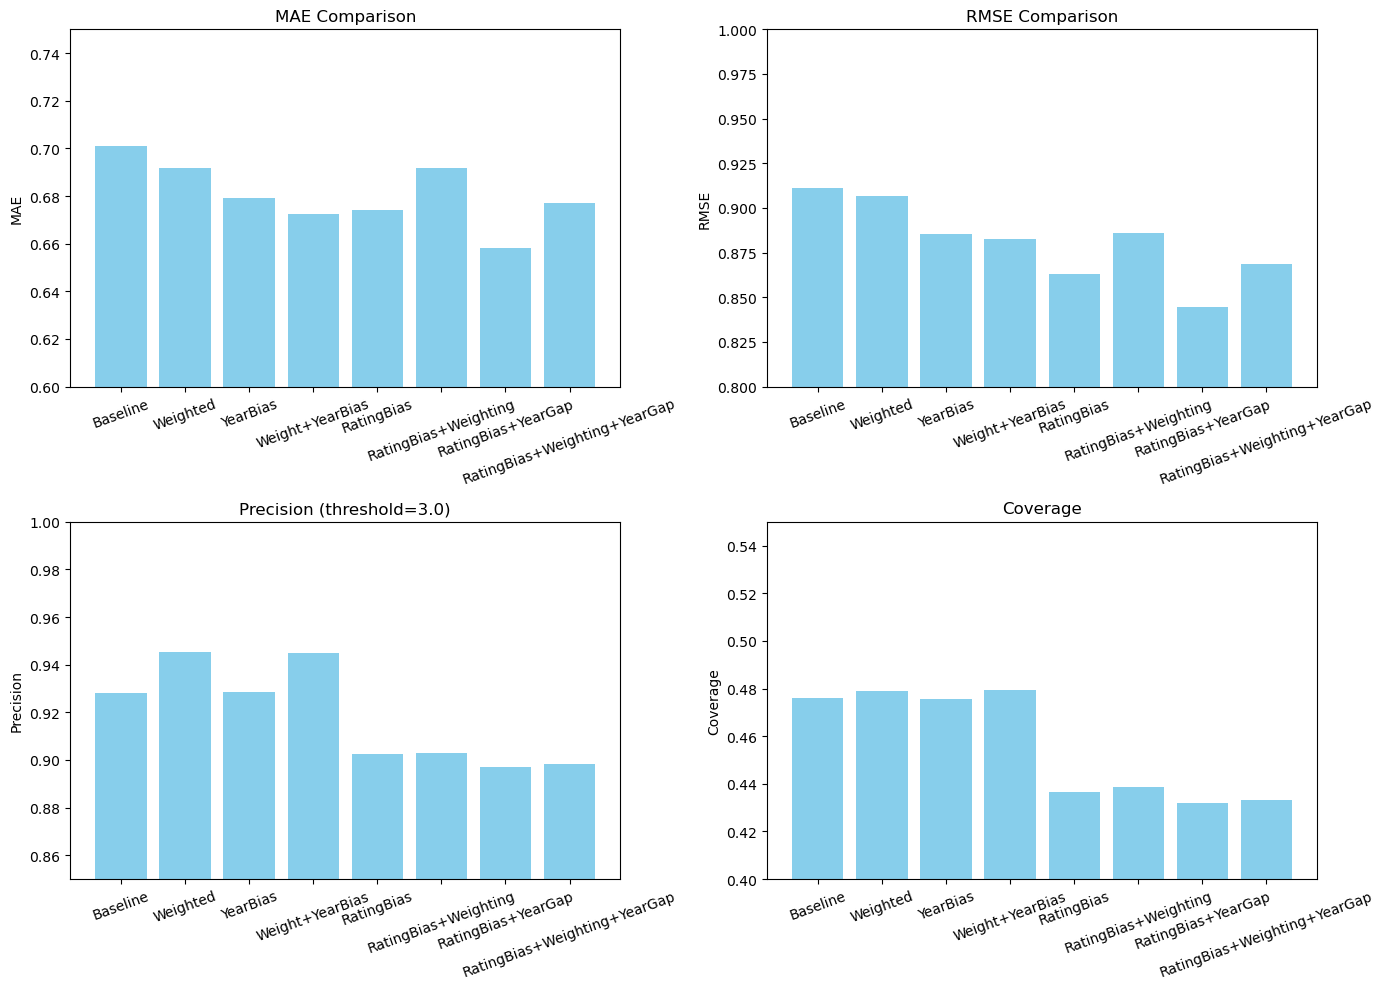

Baseline                       | MAE=0.7010 | RMSE=0.9109 | Precision=0.9280 | Coverage=0.4761
Weighted                       | MAE=0.6918 | RMSE=0.9068 | Precision=0.9454 | Coverage=0.4790
YearBias                       | MAE=0.6792 | RMSE=0.8854 | Precision=0.9287 | Coverage=0.4758
Weight+YearBias                | MAE=0.6726 | RMSE=0.8826 | Precision=0.9448 | Coverage=0.4793
RatingBias                     | MAE=0.6741 | RMSE=0.8628 | Precision=0.9023 | Coverage=0.4363
RatingBias+Weighting           | MAE=0.6918 | RMSE=0.8859 | Precision=0.9031 | Coverage=0.4388
RatingBias+YearGap             | MAE=0.6583 | RMSE=0.8443 | Precision=0.8970 | Coverage=0.4319
RatingBias+Weighting+YearGap   | MAE=0.6771 | RMSE=0.8686 | Precision=0.8983 | Coverage=0.4334


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate(all_pred_df, test_df, n_movies, threshold=3.0):
    # 테스트 데이터와 예측 결과 merge
    test = test_df.merge(all_pred_df, on=['user_id', 'title'], how='left')

    true_y = test['rating'].to_numpy()
    pred_y = test['pred_rating'].to_numpy()

    # MAE, RMSE
    mae = mean_absolute_error(true_y, pred_y)
    rmse = np.sqrt(mean_squared_error(true_y, pred_y))

    # Precision
    trues = (true_y >= threshold).astype(int)
    pred_trues = (pred_y >= threshold).astype(int)
    true_positive = np.sum((trues + pred_trues) == 2)
    n_trues = np.sum(trues)
    precision = true_positive / n_trues if n_trues > 0 else 0.0

    # Coverage
    # test 데이터에서 예측이 threshold 이상인 영화들의 고유 title 개수
    recommended_titles = test.loc[test['pred_rating'] > threshold, 'title'].unique()
    coverage = len(recommended_titles) / n_movies

    return mae, rmse, precision, coverage


# -------------------------------------------------------------------
#  8가지 설정에 대한 예측값 계산
# -------------------------------------------------------------------

# 1) Baseline
pred_base = modeling(S, R_df, movie_ratings_df)

# 2) Baseline + Similarity Weighting
weighted_S = apply_weight_similarity(S)
pred_weight = modeling(weighted_S, R_df, movie_ratings_df)

# 3) Baseline + Year-gap Bias
pred_gap = apply_year_gap_bias(pred_base, gamma=0.5)

# 4) Baseline + Weighting + Year-gap Bias
pred_weight_gap = apply_year_gap_bias(pred_weight, gamma=0.5)

# 5) Baseline + RatingBias (Mean-Centering CF)
pred_rating_bias = modeling(S_centered, R_centered, movie_ratings_df, use_centering=True)

# 6) RatingBias + Weighting
weighted_S_centered = apply_weight_similarity(S_centered)
pred_rating_bias_weight = modeling(weighted_S_centered, R_centered, movie_ratings_df, use_centering=True)

# 7) RatingBias + Year-gap Bias
pred_rating_bias_gap = apply_year_gap_bias(pred_rating_bias, gamma=0.5)

# 8) RatingBias + Weighting + Year-gap Bias
pred_rating_bias_weight_gap = apply_year_gap_bias(pred_rating_bias_weight, gamma=0.5)



# -------------------------------------------------------------------
#  테스트셋 준비
# -------------------------------------------------------------------
_, test_base = train_test_split(
    movie_ratings_df[['user_id', 'title', 'rating']],
    test_size=20000,
    random_state=1234,
    stratify=movie_ratings_df['user_id']
)

n_movies = movie_ratings_df['title'].nunique()
THRESHOLD = 3.0


# -------------------------------------------------------------------
# 모든 모델 evaluate
# -------------------------------------------------------------------
results = {}
results["Baseline"]                    = evaluate(pred_base, test_base, n_movies, THRESHOLD)
results["Weighted"]                    = evaluate(pred_weight, test_base, n_movies, THRESHOLD)
results["YearBias"]                    = evaluate(pred_gap, test_base, n_movies, THRESHOLD)
results["Weight+YearBias"]             = evaluate(pred_weight_gap, test_base, n_movies, THRESHOLD)
results["RatingBias"]                  = evaluate(pred_rating_bias, test_base, n_movies, THRESHOLD)
results["RatingBias+Weighting"]        = evaluate(pred_rating_bias_weight, test_base, n_movies, THRESHOLD)
results["RatingBias+YearGap"]          = evaluate(pred_rating_bias_gap, test_base, n_movies, THRESHOLD)
results["RatingBias+Weighting+YearGap"] = evaluate(pred_rating_bias_weight_gap, test_base, n_movies, THRESHOLD)


# -------------------------------------------------------------------
# 시각화
# -------------------------------------------------------------------
labels = list(results.keys())
mae_values       = [results[k][0] for k in labels]
rmse_values      = [results[k][1] for k in labels]
precision_values = [results[k][2] for k in labels]
coverage_values  = [results[k][3] for k in labels]

plt.figure(figsize=(14, 10))

# MAE
plt.subplot(2, 2, 1)
plt.bar(labels, mae_values, color='skyblue')
plt.title("MAE Comparison")
plt.ylabel("MAE")
plt.ylim(0.60, 0.75) 
plt.xticks(rotation=20)

# RMSE
plt.subplot(2, 2, 2)
plt.bar(labels, rmse_values, color='skyblue')
plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.ylim(0.80, 1.00) 
plt.xticks(rotation=20)

# Precision
plt.subplot(2, 2, 3)
plt.bar(labels, precision_values, color='skyblue')
plt.title(f"Precision (threshold={THRESHOLD})")
plt.ylabel("Precision")
plt.ylim(0.85, 1.00)
plt.xticks(rotation=20)

# Coverage
plt.subplot(2, 2, 4)
plt.bar(labels, coverage_values, color='skyblue')
plt.title("Coverage")
plt.ylabel("Coverage")
plt.ylim(0.40, 0.55)
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()


# -------------------------------------------------------------------
# 수치 출력
# -------------------------------------------------------------------
for name, (mae, rmse, prec, cov) in results.items():
    print(f"{name:30s} | MAE={mae:.4f} | RMSE={rmse:.4f} | Precision={prec:.4f} | Coverage={cov:.4f}")

RatingBias 모델들은 Coverage가 낮아짐  
RatingBias로 인해 centered-rating 기반 유사도가 sharpen되면서 추천되는 아이템 풀이 좁아지는 현상이 발생함. 

# 아이템 유사도 기반 추천

In [20]:
# 사용자가 안본 영화 중 예측 평점 높은 10개 추천
def get_recomendation(
        movie_ratings_df,
        all_pred_df,
        user_id
    ):
    user_movie_df = movie_ratings_df[movie_ratings_df['user_id'] == user_id]
    user_movie_pred_df = all_pred_df[all_pred_df['user_id'] == user_id]

    user_movie_df = pd.merge(user_movie_df, user_movie_pred_df,
                             on=['user_id',  'title'], how='right')

    # 사용자가 아직 안 본 영화
    movie_candidate_df = user_movie_df[user_movie_df['movie_id'].isnull()]
    movie_candidate_df = movie_candidate_df.sort_values(by='pred_rating', ascending=False)[:10]
    print(movie_candidate_df.shape)
    return movie_candidate_df['title'].tolist()

In [21]:
S_W = apply_weight_similarity(S) # 유사도 행렬 가중치
all_pred_df = modeling(S_W, R_df, movie_ratings_df) # dot production 예측
all_pred_df = apply_year_gap_bias(all_pred_df, gamma=0.5) # 연도 갭차이 편향 적용

get_recomendation(movie_ratings_df, all_pred_df, user_id='1')

(10, 10)


['Entertaining Angels: The Dorothy Day Story (1996)',
 'The Emoji Movie (2017)',
 'Circus (2000)',
 'The Night Is Short, Walk on Girl (2017)',
 'Fullmetal Alchemist 2018 (2017)',
 'Sword Art Online The Movie: Ordinal Scale (2017)',
 'Fireworks, Should We See It from the Side or the Bottom? (2017)',
 'Shot Caller (2017)',
 'The Clapper (2018)',
 'Kizumonogatari III: Cold Blood (2017)']